In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import optim
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv

In [2]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

In [3]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        # Create two convolutional layers

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # Extract features and the index of nodes and their connections

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        # Pass through the first graph convolution layer, apply non-linearity and dropout
        # Here, x and edge_index are passed as arguments, representing node features and their connections

        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)
        # Pass through the second graph convolution layer and apply log_softmax to prevent numerical instability

In [4]:
model = GCN(num_features=dataset.num_node_features,
            hidden_channels=16,
            num_classes=dataset.num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# Build the model and use the Adam optimizer

In [5]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()
    # Train the model

def test():
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    # Select the class with the highest probability

    correct = pred[data.test_mask] == data.y[data.test_mask]
    acc = int(correct.sum()) / int(data.test_mask.sum())
    # Calculate accuracy

    return acc

In [6]:
losses = []
accuracies = []

for epoch in range(1, 101):
    loss = train()
    acc = test()
    losses.append(loss)
    accuracies.append(acc)
    # For plotting later
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Acc: {acc*100:.2f}')
        # Compute accuracy every 10 epochs

Epoch: 10, Loss: 0.8889, Acc: 72.50
Epoch: 20, Loss: 0.3039, Acc: 80.20
Epoch: 30, Loss: 0.1139, Acc: 78.90
Epoch: 40, Loss: 0.0653, Acc: 78.40
Epoch: 50, Loss: 0.0691, Acc: 78.90
Epoch: 60, Loss: 0.0406, Acc: 79.20
Epoch: 70, Loss: 0.0486, Acc: 79.20
Epoch: 80, Loss: 0.0410, Acc: 79.10
Epoch: 90, Loss: 0.0405, Acc: 78.60
Epoch: 100, Loss: 0.0296, Acc: 79.90


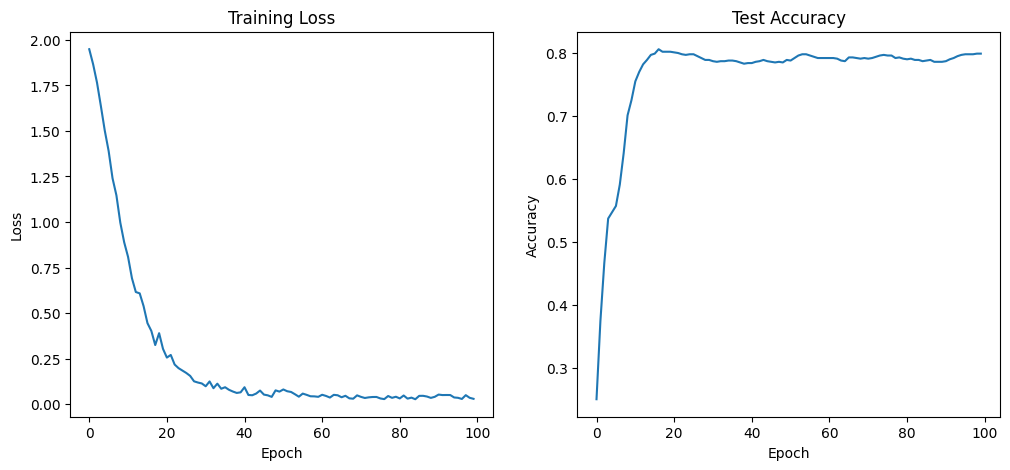

In [7]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [8]:
model.eval()
out = model(data)
pred = out.argmax(dim=1)

test_indices = data.test_mask.nonzero(as_tuple=True)[0]
test_indices = test_indices[torch.randperm(test_indices.size(0))]
# Extract the indices of test set nodes and shuffle their order

for idx in test_indices[:5]:
    print(f'Node {idx.item()}: Predicted class {pred[idx].item()}, True class {data.y[idx].item()}')

Node 2214: Predicted class 3, True class 3
Node 2610: Predicted class 3, True class 3
Node 1938: Predicted class 2, True class 3
Node 1804: Predicted class 1, True class 2
Node 2511: Predicted class 0, True class 0
